# Modelling of !Kung people heights

In [12]:
import sys
sys.path.append('../../Utilities/src')

from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import pandas as pd


In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [14]:
from DA_tools.DA_tools import ribbon_plot
from DA_tools.DA_colors import *

### Loading data

In [15]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"


In [16]:
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults for now
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

### Prior predictive checks

In [17]:
with open('height_1_ppc.stan', 'r') as file:
    print(file.read())


generated quantities {
  real mu = normal_rng(178,20);
  real sigma = exponential_rng(0.067);
  real height = normal_rng(mu,sigma);
}



In [18]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpzivd7xry/tmpz38w7kgv
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 6 - Linear models/Kung_people/height_1_ppc


In [19]:
R = 1000
sim=model_ppc.sample(iter_sampling=R, iter_warmup=0,chains=1,fixed_param=True,seed=29042020,refresh=R)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [20]:
mu_sim=sim.stan_variable('mu')
sigma_sim=sim.stan_variable('sigma')
height_sim=sim.stan_variable('height')

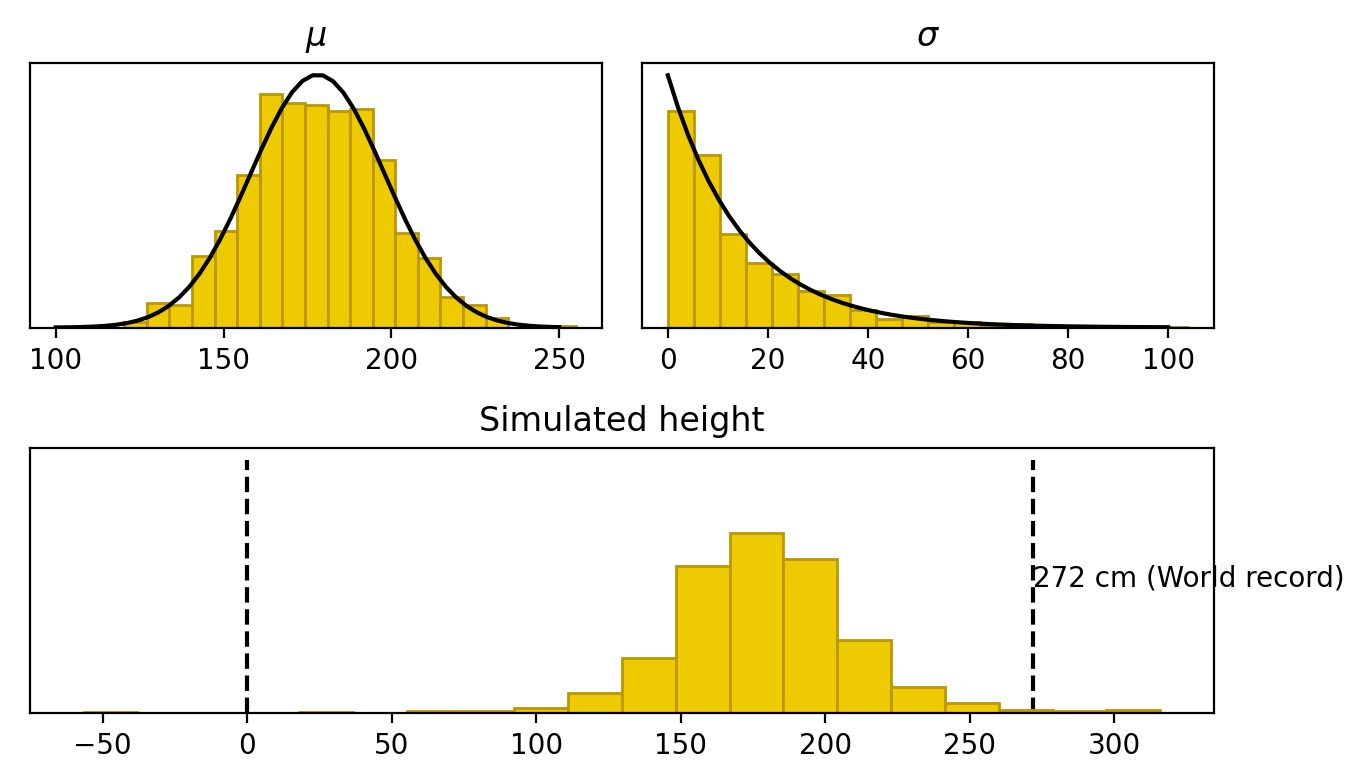

In [21]:
fig = plt.figure(figsize=(7, 4))

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[1, :])
ax1.hist(height_sim,bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax1.vlines([0,272],ymin=0,ymax=2e-2,linestyle='--',color='black',zorder=1)
ax1.set_yticks([])
ax1.set_title('Simulated height')

ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax2.set_yticks([])
ax2.hist(mu_sim,bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
x=np.linspace(100,250)
y=stats.norm.pdf(x,loc=178,scale=20)
ax2.plot(x,y,'black')
#ax2.set_xticks([-4,0,4])
ax2.set_title('$\mu$')
ax3.set_yticks([])
ax2.set_yticks([])
ax3.hist(sigma_sim,bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
#ax3.set_xticks([-8,0,8])
x=np.linspace(0,100)
y=stats.expon.pdf(x,scale=15)
ax3.plot(x,y,color='black')
ax3.set_title('$\sigma$')
ax1.annotate(text='272 cm (World record)',xy=(272,0.01))

fig.tight_layout()
plt.show()

### Posterior and inference

In [22]:
with open('height_1_fit.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real heights[N];
}

parameters {
  real mu;
  real<lower=0> sigma;
}

model {
  mu ~ normal(178,20);
  sigma ~ exponential(0.067);
  heights ~ normal(mu,sigma);
}

generated quantities {
  real height = normal_rng(mu,sigma);
}



In [23]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpt64if446/tmpaqokx080
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 6 - Linear models/Kung_people/height_1_fit


In [24]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


In [25]:
az.summary(fit,var_names=['mu','sigma'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu,154.60,0.41,153.91,155.46
sigma,7.77,0.29,7.18,8.28


In [26]:
mu_fit=fit.stan_variable('mu')
sigma_fit=fit.stan_variable('sigma')
height_pred=fit.stan_variable('height')

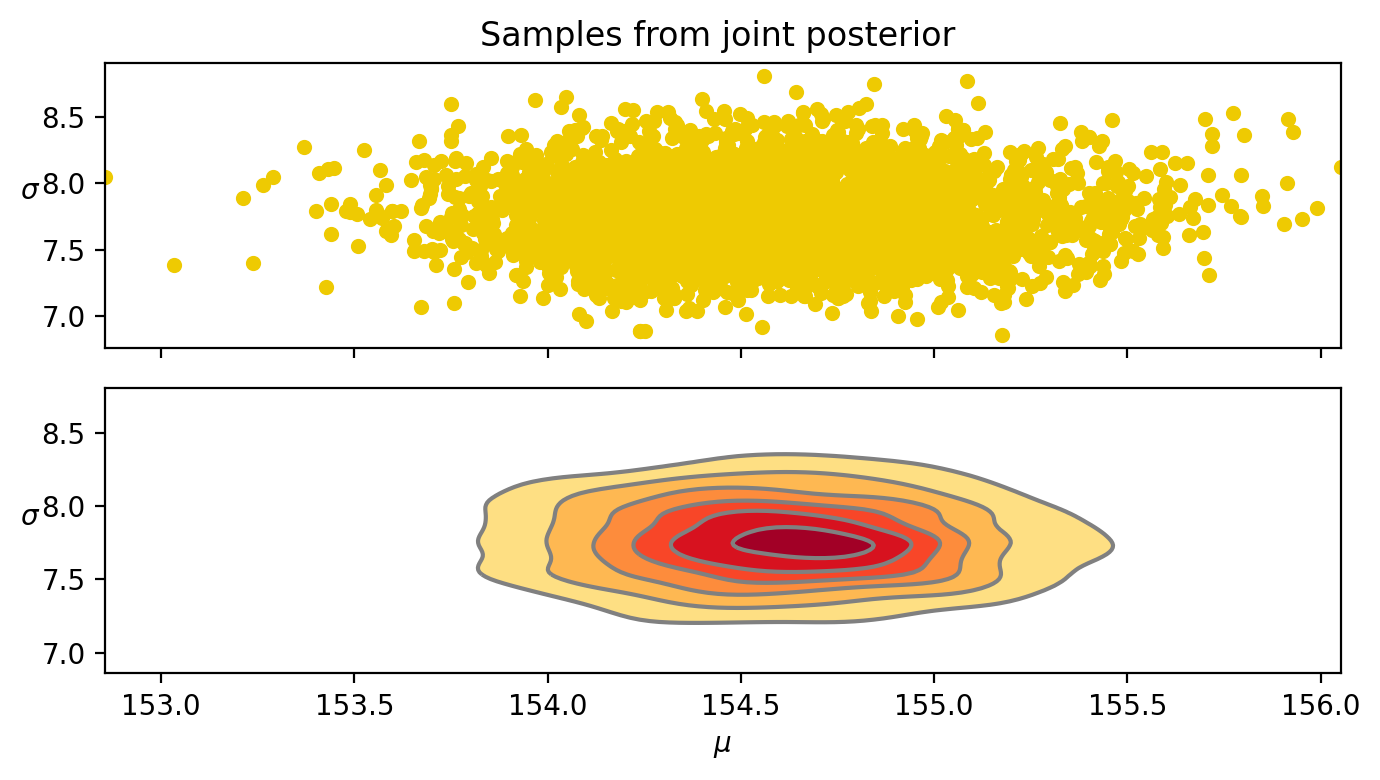

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(7, 4),sharex=True)
ax1=axes[0]
ax1.scatter(mu_fit, sigma_fit, 20, color=DARK)
ax1.set_ylabel(r'$\sigma$',rotation=0)
ax1.set_title('Samples from joint posterior ')
ax2=axes[1]
az.plot_kde(mu_fit,sigma_fit,ax=ax2,contourf_kwargs={'cmap':'YlOrRd'})
fig.tight_layout()
ax2.set_xlabel(r'$\mu$')
ax2.set_ylabel(r'$\sigma$',rotation=0)
fig.tight_layout()

plt.show()

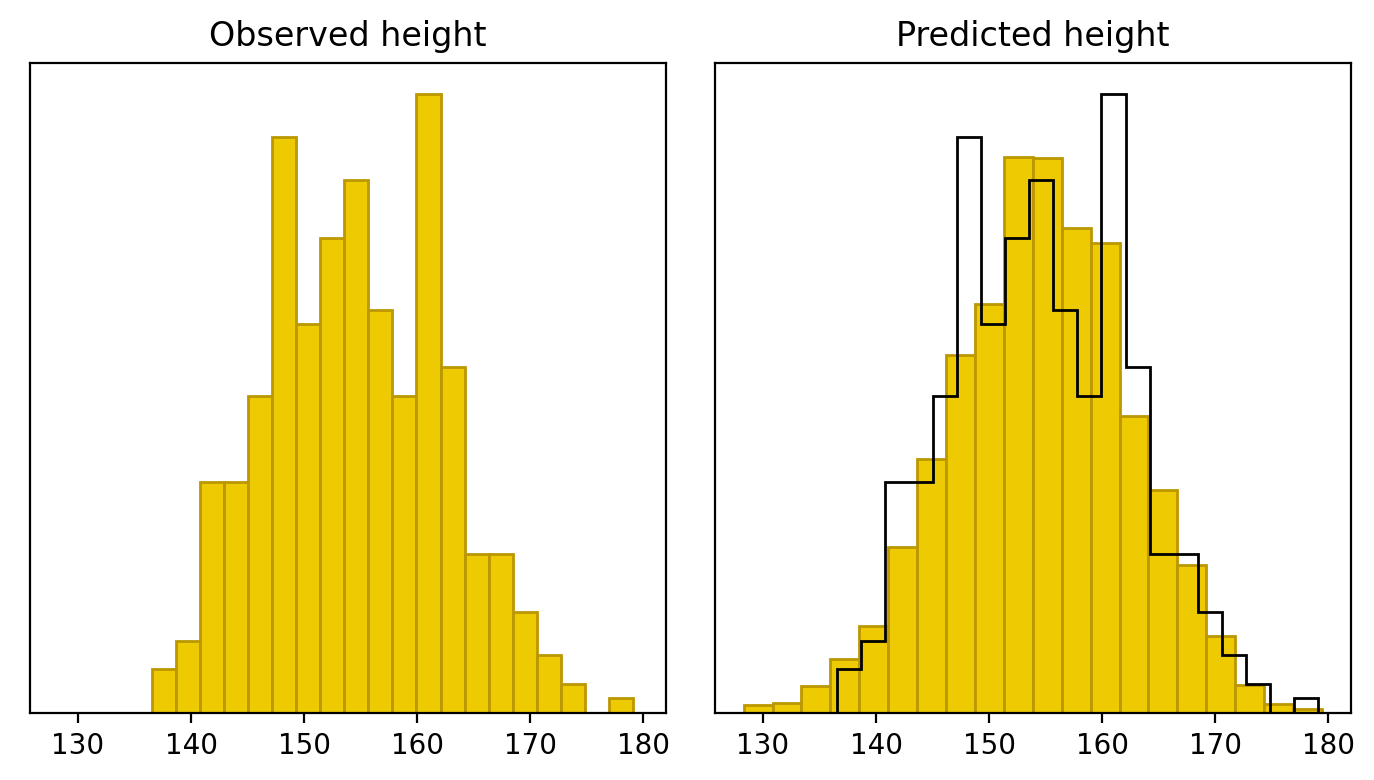

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4),sharex=True,sharey=True)
ax=axes[0]
ax.hist(d.height,bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax.set_title('Observed height')
ax.set_yticks(())
ax2=axes[1]
ax2.hist(height_pred,bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.hist(d.height,bins=20,histtype='step',color='black',density=True)

ax2.set_title('Predicted height')
ax2.set_yticks(())
fig.tight_layout()

plt.show()

## Improving model - adding a predictor
Natural extension for our model is to add a predictor, in our case weight.


### Centering of variables

In [29]:
d['c_weight']=d.weight-d.weight.mean()
d.head()

,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,2.835121
1,139.700,36.485807,63.0,0,-8.504679
2,136.525,31.864838,65.0,0,-13.125648
3,156.845,53.041914,41.0,1,8.051429
4,145.415,41.276872,51.0,0,-3.713614


### Prior predictive checks

In [30]:
with open('height_2a_ppc.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real weight[N];
}

generated quantities {
  real alpha = normal_rng(178,20);
  real beta = normal_rng(0,10);
  real sigma = exponential_rng(0.067);
  real height[N];
  for (i in 1:N) {
    height[N] = normal_rng(weight[N]*beta+alpha,sigma);
  }

}



In [31]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpzd_95j9c/tmp0r0cp70s
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 6 - Linear models/Kung_people/height_2a_ppc


In [32]:
R = 1000
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [33]:
alpha_sim=sim.stan_variable('alpha')
beta_sim=sim.stan_variable('beta')


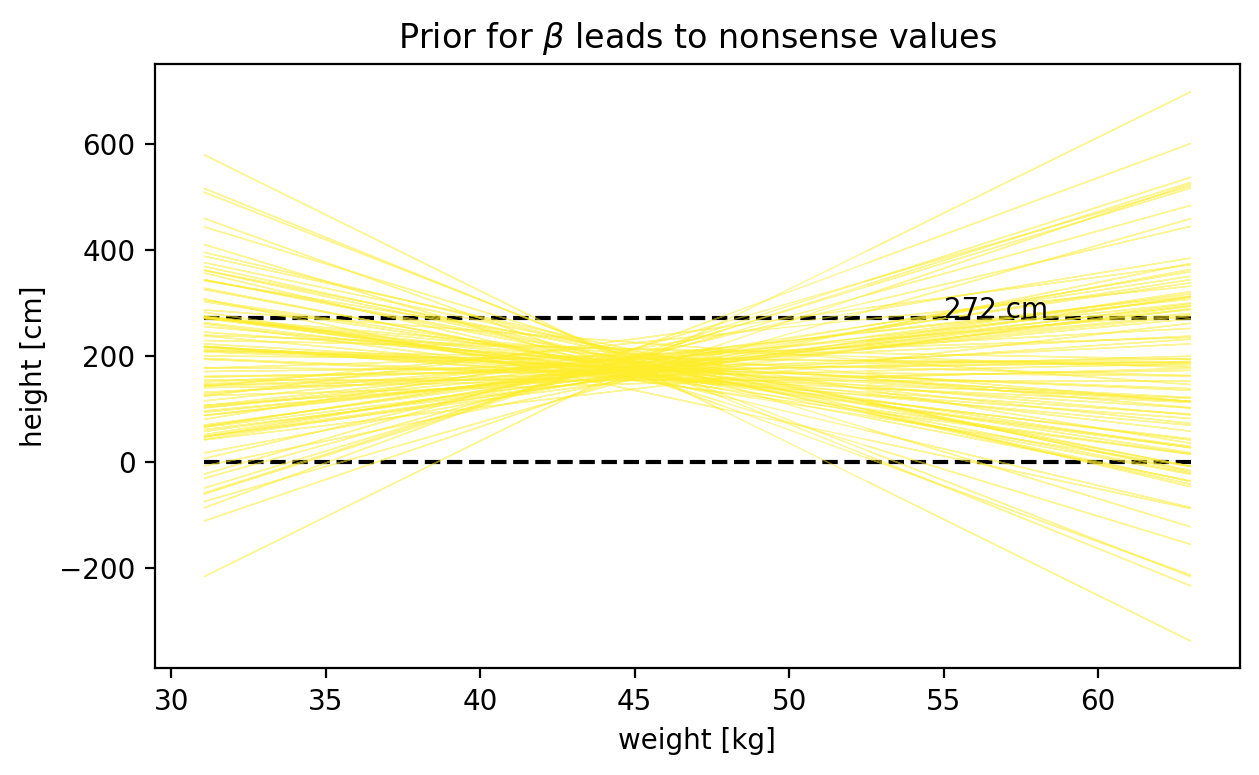

In [34]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([0,272],xmin=d.weight.min(),xmax=d.weight.max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(d.weight,alpha_sim[i]+beta_sim[i]*d.c_weight,color=MID,alpha=0.5,linewidth=0.5)
axes.set_xlabel('weight [kg]')
axes.set_ylabel('height [cm]')
axes.set_title(r'Prior for $\beta$ leads to nonsense values')
axes.annotate(text='272 cm', xy=(55,272))
plt.show()

### Prior modification

In [35]:
with open('height_2b_ppc.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real weight[N];
}

generated quantities {
  real alpha = normal_rng(178,20);
  real beta = lognormal_rng(0,1);
  real sigma = exponential_rng(0.067);
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(weight[i]*beta+alpha,sigma);
  }

}



In [36]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpikuc0a4_/tmpb19m3t8d
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 6 - Linear models/Kung_people/height_2b_ppc


In [37]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [38]:
alpha_sim=sim.stan_variable('alpha')
beta_sim=sim.stan_variable('beta')


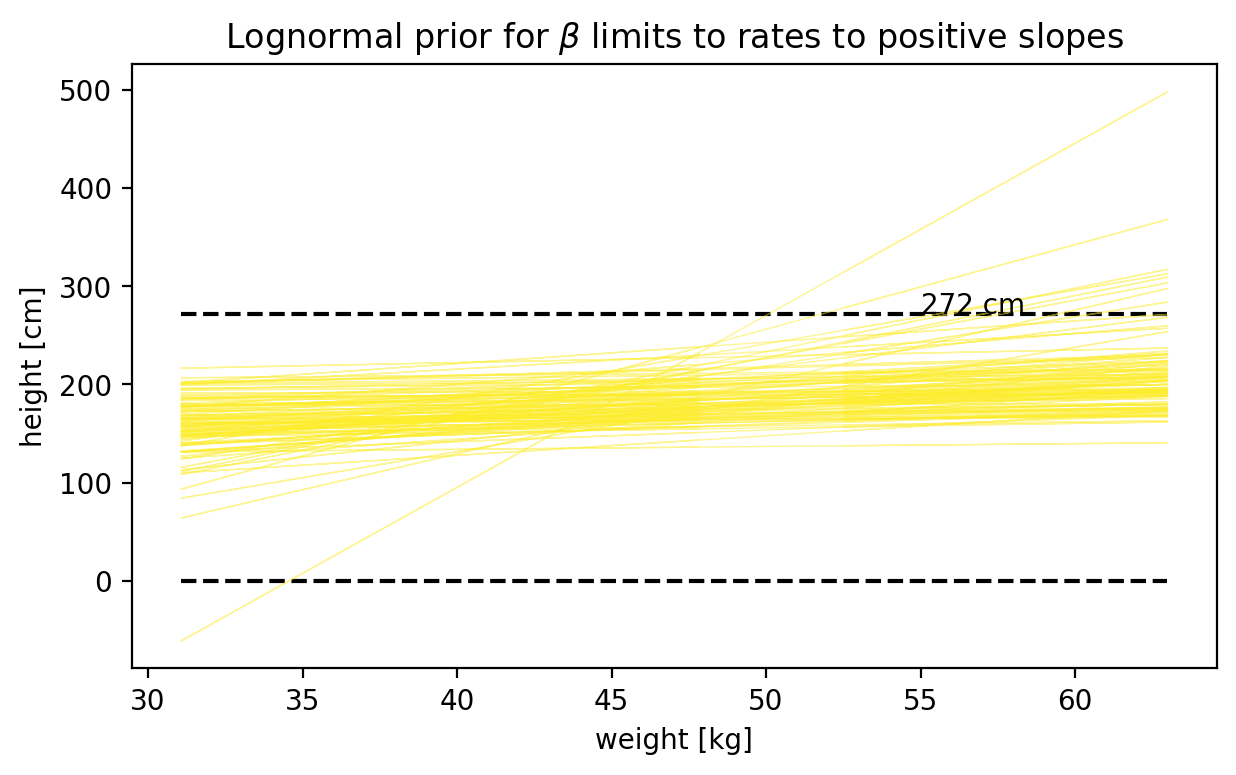

In [39]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([0,272],xmin=d.weight.min(),xmax=d.weight.max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(d.weight,alpha_sim[i]+beta_sim[i]*d.c_weight,color=MID,alpha=0.5,linewidth=0.5)
axes.set_xlabel('weight [kg]')
axes.set_ylabel('height [cm]')
axes.annotate(text='272 cm', xy=(55,272))
axes.set_title(r'Lognormal prior for $\beta$ limits to rates to positive slopes')
plt.show()

In [40]:
height_sim=sim.stan_variable('height')

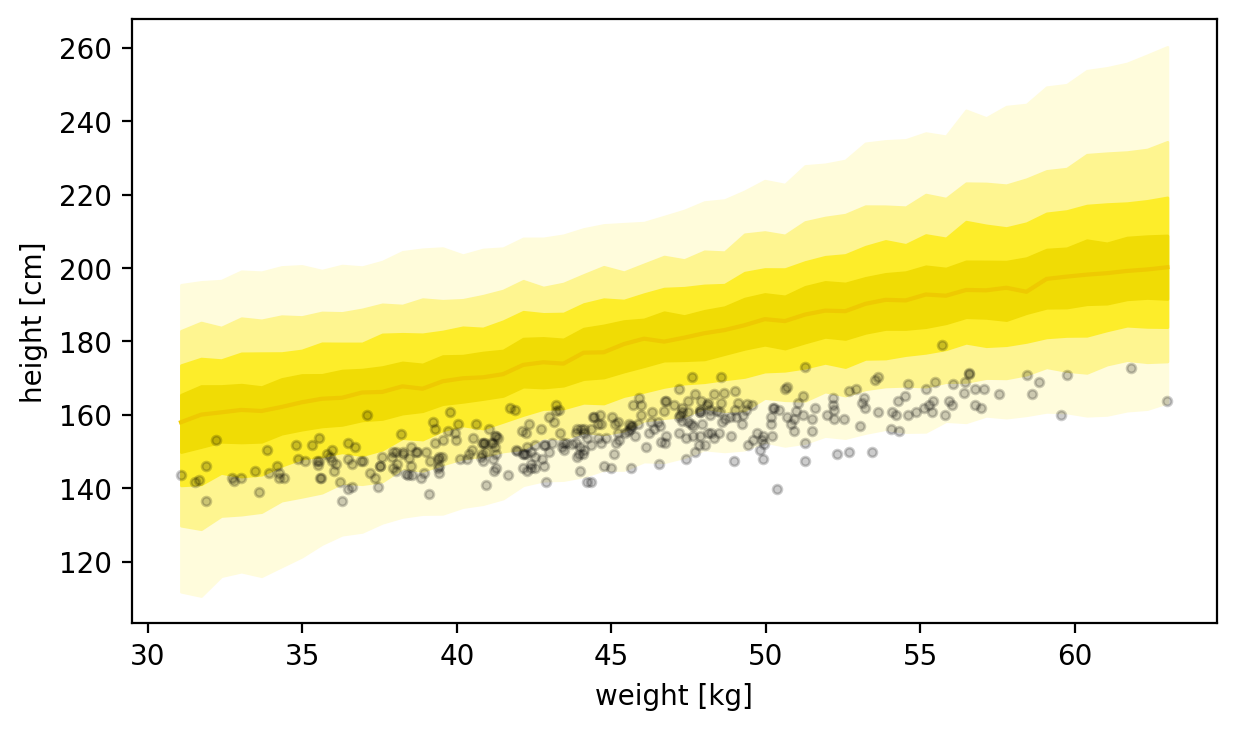

In [41]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes=ribbon_plot(data_sim['weight']+d.weight.mean(),height_sim,axes)
axes.scatter(d.weight,d.height,color='black',alpha=0.2,s=10)
axes.set_xlabel('weight [kg]')
axes.set_ylabel('height [cm]')
plt.show()

### Posterior inference

In [42]:
with open('height_2_fit.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] weight;
  real heights[N];
}

parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu = weight*beta+alpha;
}

model {
  alpha ~ normal(178,20);
  beta ~ lognormal(0,1);
  sigma ~ exponential(0.067);
  heights ~ normal(mu,sigma);
}

generated quantities {
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(mu[i],sigma);
  }
}



In [43]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpagnvv_yb/tmpefurtmzz
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 6 - Linear models/Kung_people/height_2_fit


In [44]:
model_2_fit.compile(force=False)

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpxz4lb_5u/tmppja0tp79
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 6 - Linear models/Kung_people/height_2_fit


In [45]:
d_short=d.head(150)

data_fit=dict(N=len(d_short),
              weight=d_short.c_weight.values,
              heights=d_short.height.values)

fit=model_2_fit.sample(data=data_fit,seed=28052020)
alpha_fit=fit.stan_variable('alpha')
beta_fit=fit.stan_variable('beta')
mu_fit=fit.stan_variable('mu')
height_pred=fit.stan_variable('height')

az.summary(fit,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


,mean,sd,hdi_3%,hdi_97%
alpha,153.83,0.44,153.04,154.68
beta,0.90,0.06,0.78,1.02
sigma,5.50,0.32,4.89,6.09


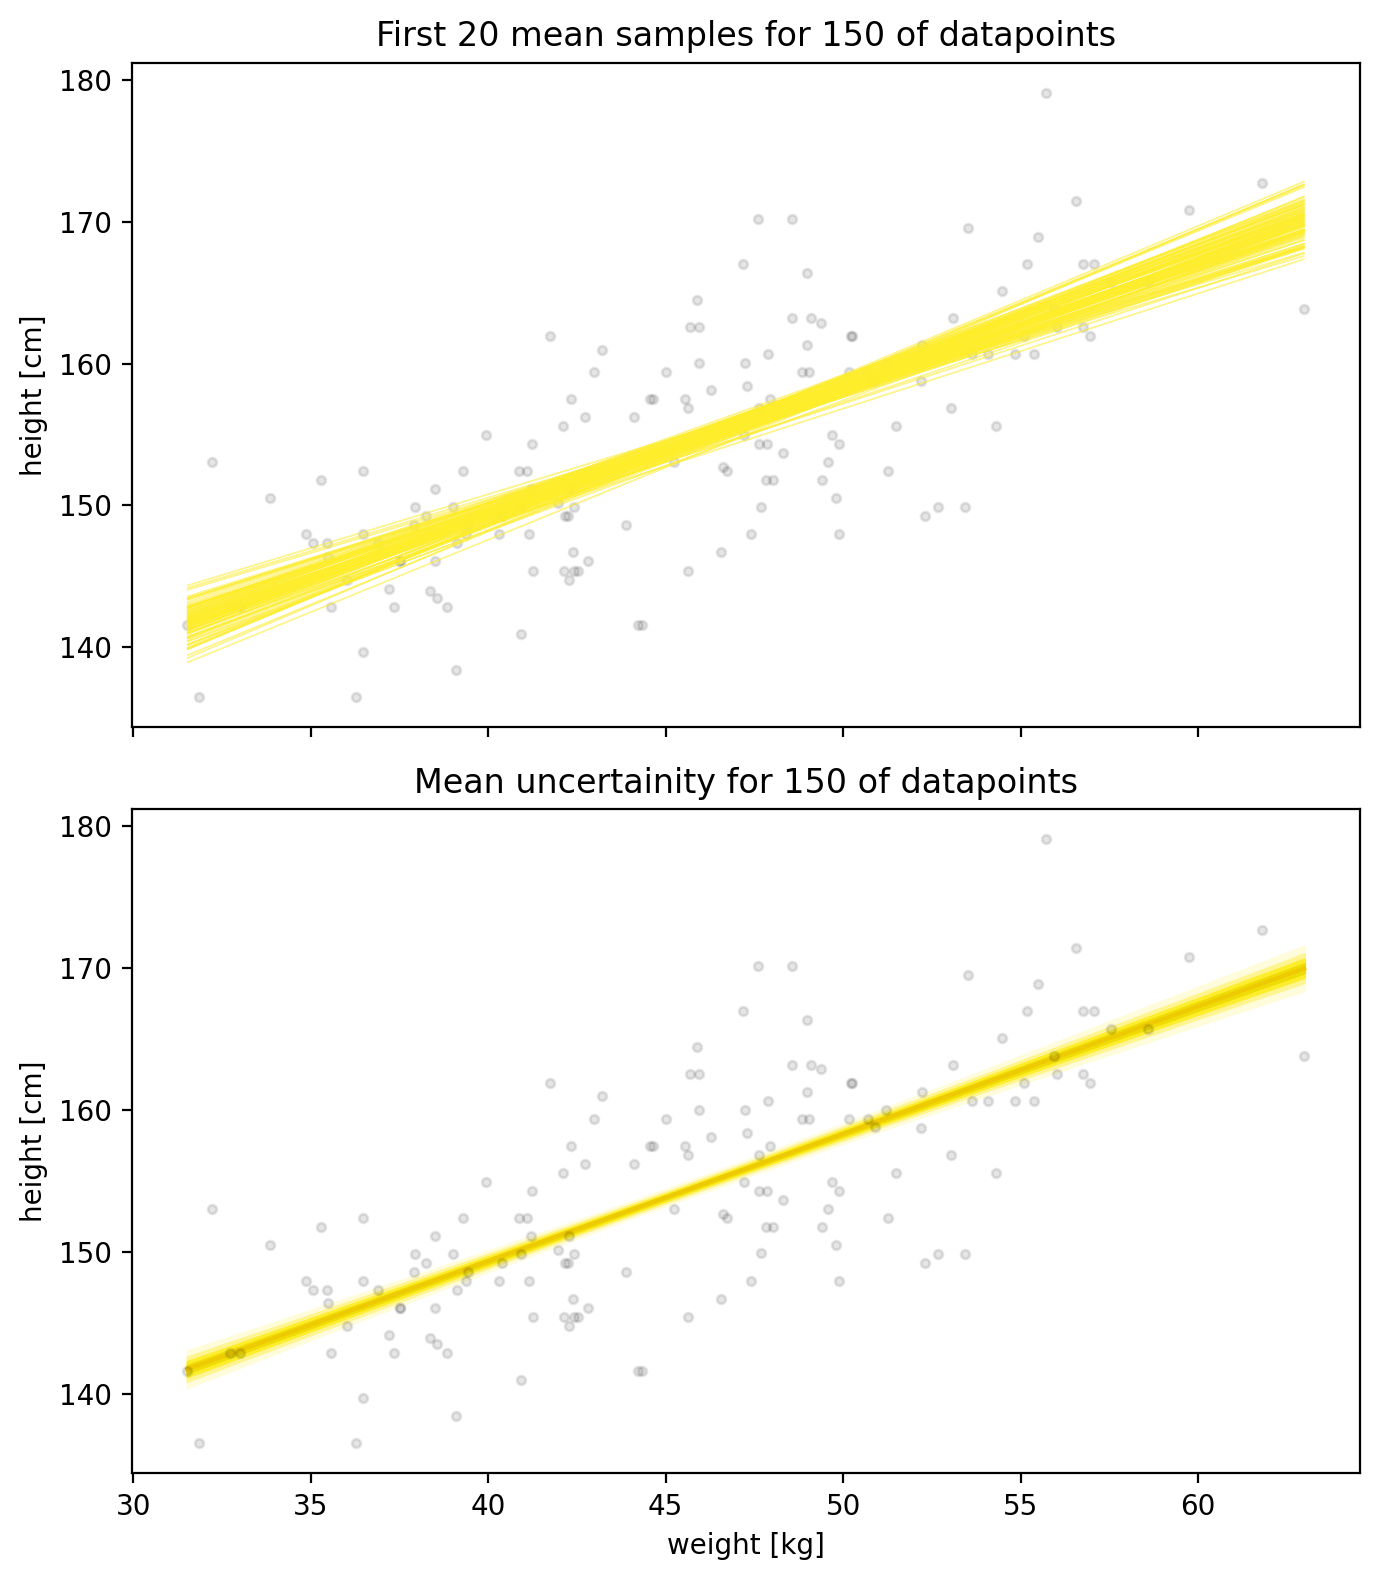

In [46]:
fig, axes = plt.subplots(2,1, figsize=(7, 8),sharey=True,sharex=True)
ax0=axes[0]
for i in range(100):
    ax0.plot(d_short.weight,
              alpha_fit[i]+beta_fit[i]*d_short.c_weight,
              color=MID,
              alpha=0.5,linewidth=0.5)
ax0.scatter(d_short.weight,d_short.height,color='black',alpha=0.1,s=10)
ax0.set_ylabel('height [cm]')
ax0.set_title('First 20 mean samples for {} of datapoints'.format(len(d_short)))
ax1=axes[1]
ax1=ribbon_plot(d_short.weight.values,mu_fit,ax1,supress_warning=True)
ax1.scatter(d_short.weight,d_short.height,color='black',alpha=0.1,s=10)
ax1.set_xlabel('weight [kg]')
ax1.set_ylabel('height [cm]')

ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(d_short)))
fig.tight_layout()
plt.show()

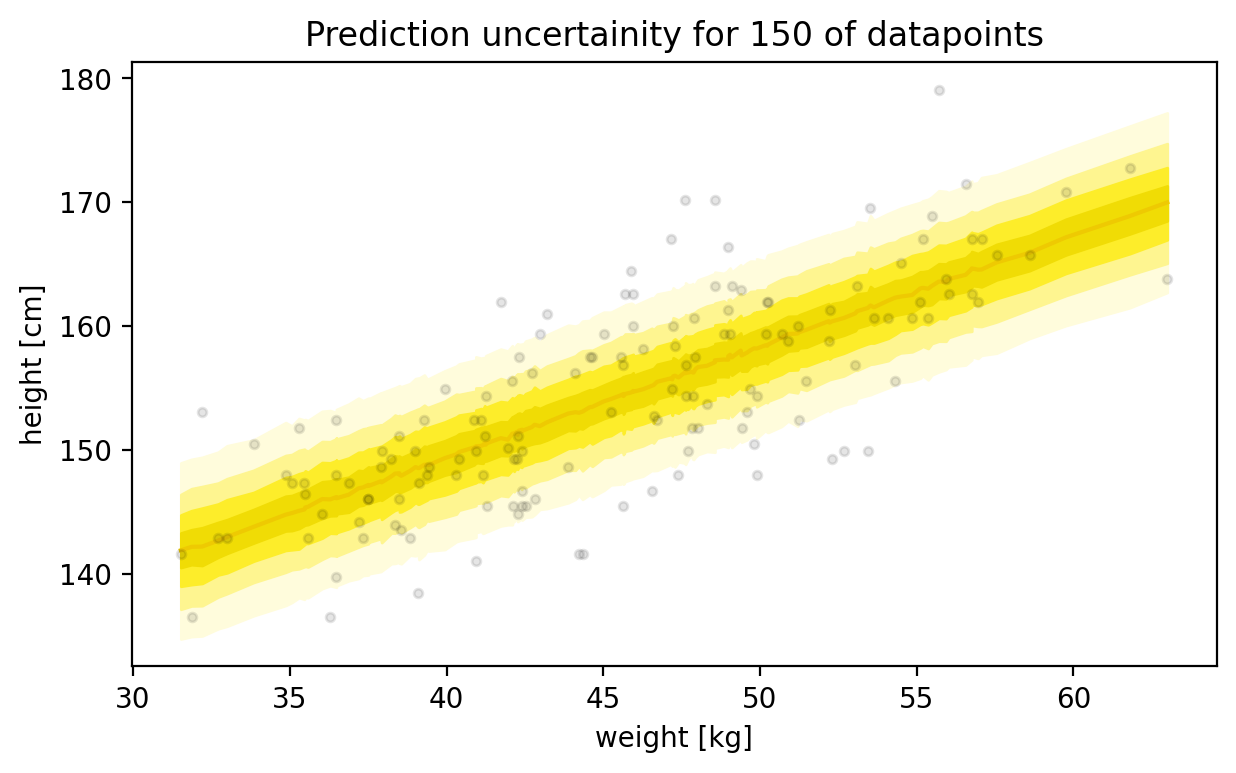

In [47]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(d_short.weight.values,height_pred,axes,supress_warning=True)
axes.scatter(d_short.weight,d_short.height,color='black',alpha=0.1,s=10)
axes.set_xlabel('weight [kg]')
axes.set_ylabel('height [cm]')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short)))
plt.show()


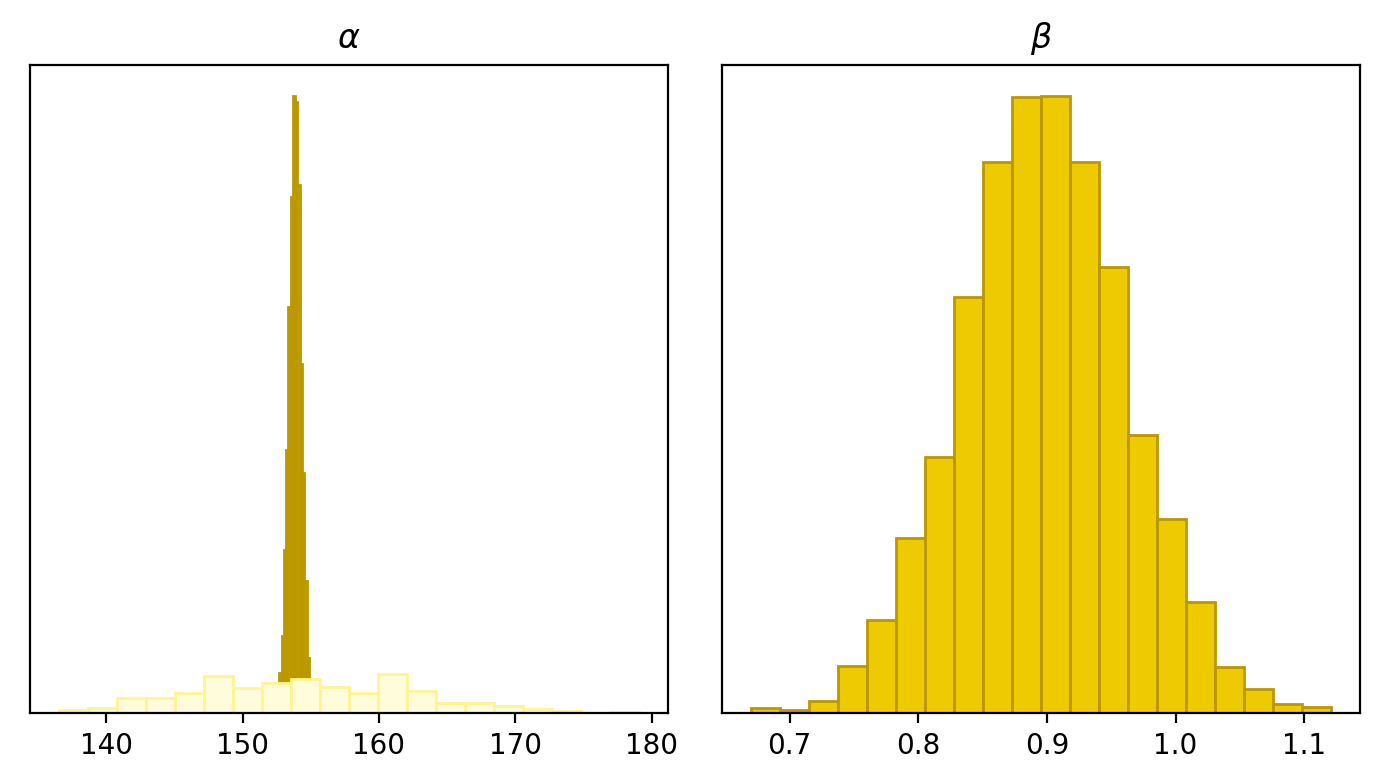

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax = axes[0]
ax.hist(alpha_fit,bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax.hist(d.height,bins=20,color=LIGHT,edgecolor=LIGHT_HIGHLIGHT,density=True)
ax.set_title(r'$\alpha$')
ax.set_yticks(())
ax2 = axes[1]
ax2.hist(beta_fit,bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.set_title(r'$\beta$')
ax2.set_yticks(())
fig.tight_layout()
plt.show()

### Marginal for selected weight
What if we want to focus on predictions for selected weight?

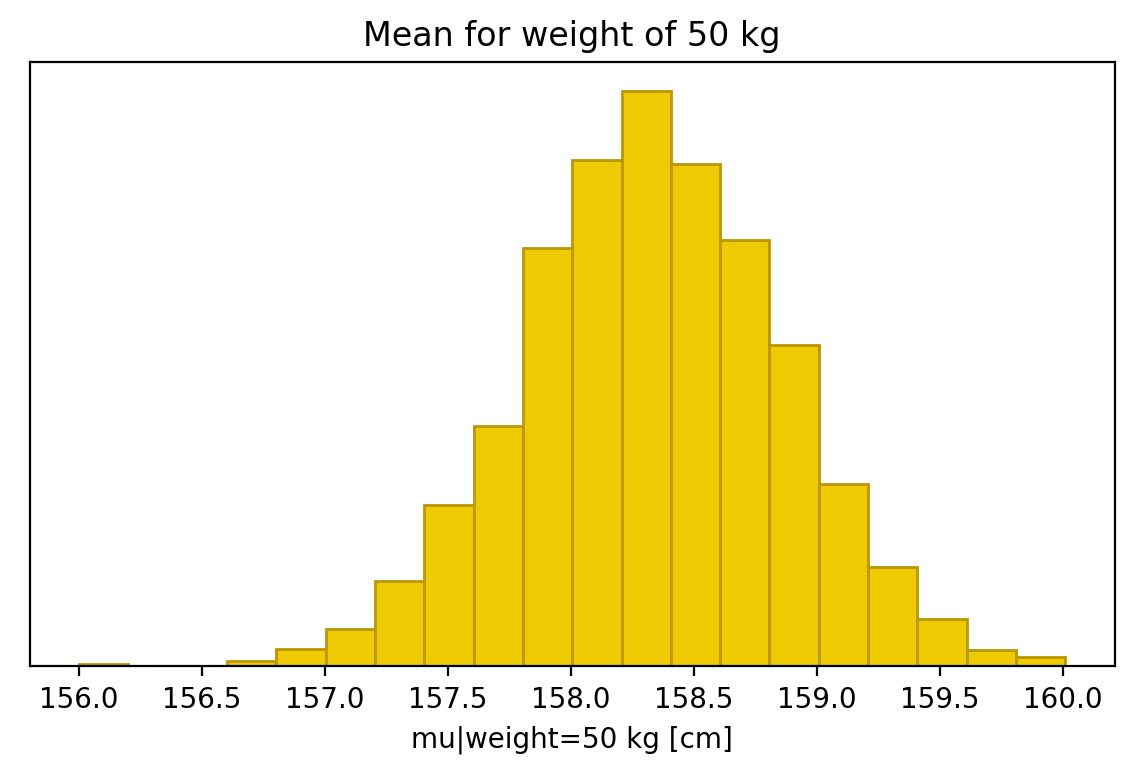

In [49]:
mu50 = alpha_fit+beta_fit*(50-d.weight.mean())

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(mu50,bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax.set_title('Mean for weight of 50 kg')
ax.set_yticks(())
ax.set_xlabel('mu|weight=50 kg [cm]')
plt.show()

### Extending of the dataset
We will now consider full dataset including children.

In [50]:
d= pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)

### Standarization of variables

In [51]:
d['c_weight']=d.weight-d.weight.mean()
d['s_weight']=d['c_weight']/d['weight'].std()
d.head()

,height,weight,age,male,c_weight,s_weight
0,151.765,47.825606,63.0,1,12.214989,0.829869
1,139.700,36.485807,63.0,0,0.875189,0.059459
2,136.525,31.864838,65.0,0,-3.745780,-0.254483
3,156.845,53.041914,41.0,1,17.431297,1.184257
4,145.415,41.276872,51.0,0,5.666254,0.384957


### How our model works for that one?

In [52]:
data_fit=dict(N=len(d),
              weight=d.s_weight.values,
              heights=d.height.values)

fit=model_2_fit.sample(data=data_fit,seed=28052020)

alpha_fit=fit.stan_variable('alpha')
beta_fit=fit.stan_variable('beta')
mu_fit=fit.stan_variable('mu')
height_pred=fit.stan_variable('height')


az.summary(fit,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


,mean,sd,hdi_3%,hdi_97%
alpha,138.29,0.41,137.56,139.10
beta,25.95,0.41,25.23,26.76
sigma,9.38,0.29,8.85,9.91


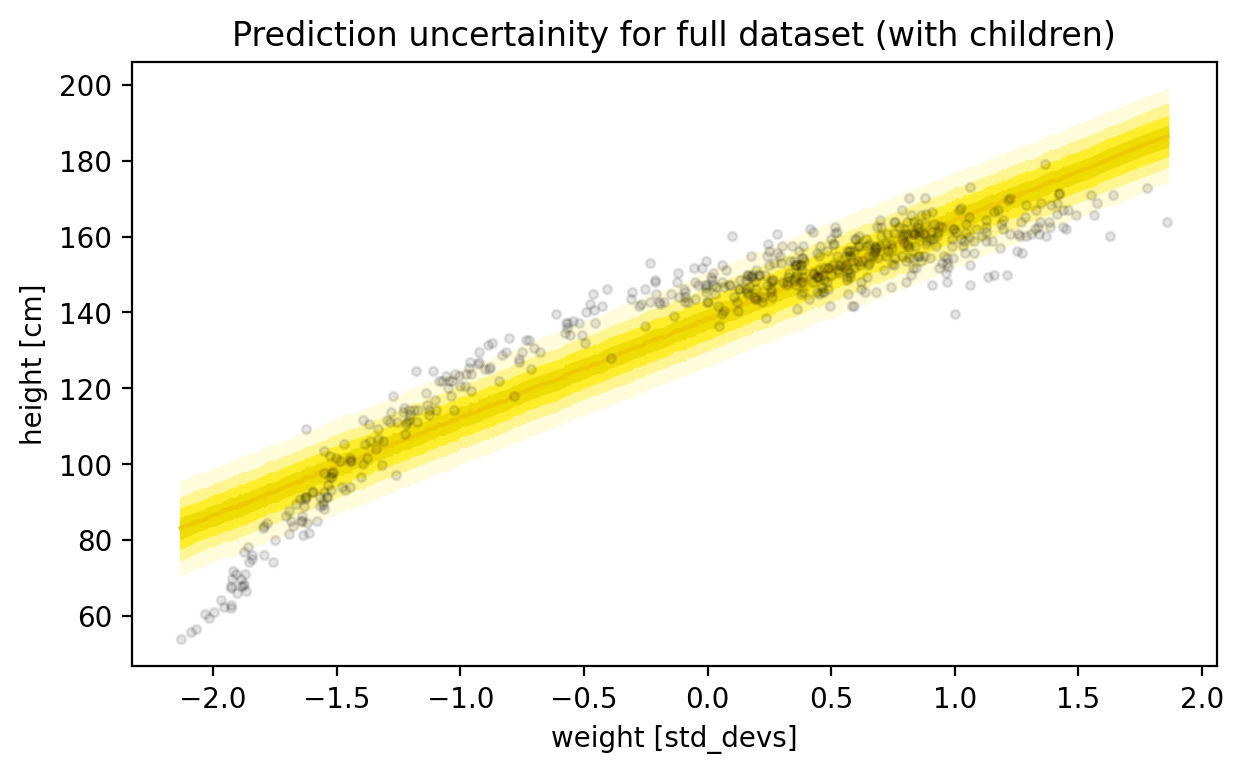

In [53]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes=ribbon_plot(d.s_weight.values,height_pred,axes,supress_warning=True)
axes.scatter(d.s_weight,d.height,color='black',alpha=0.1,s=10)
axes.set_xlabel('weight [std_devs]')
axes.set_ylabel('height [cm]')
axes.set_title('Prediction uncertainity for full dataset (with children)')
plt.show()


### Adding higher orders
Our data for the entire dataset expresses much more curvature than the linear model can capture.
Lets extend our model by adding quadratic term i.e.
$$
\mu_i = \alpha+\beta_1\cdot\mathrm{weight}_i+\beta_2\cdot\mathrm{weight}_i^2
$$

### Prior predictive checks

In [54]:
with open('height_3_ppc.stan', 'r') as file:
    print(file.read())

data {
  int N;
  real weight[N];
}

generated quantities {
  real alpha = normal_rng(178,20);
  real beta_1 = lognormal_rng(0,1);
  real beta_2 = normal_rng(0,10);
  real sigma = exponential_rng(0.067);
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(weight[i]*beta_1+weight[i]^2*beta_2+alpha,sigma);
  }

}



In [55]:
model_3_ppc=CmdStanModel(stan_file='height_3_ppc.stan')

R = 1000
data_sim=dict(N=50,weight=np.linspace(d.s_weight.min(),d.s_weight.max()))
sim=model_3_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)


INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmp5hoc4q3z/tmph9sg8ykb
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 6 - Linear models/Kung_people/height_3_ppc
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [56]:

alpha_sim=sim.stan_variable('alpha')
beta_1_sim=sim.stan_variable('beta_1')
beta_2_sim=sim.stan_variable('beta_2')
height_sim=sim.stan_variable('height')

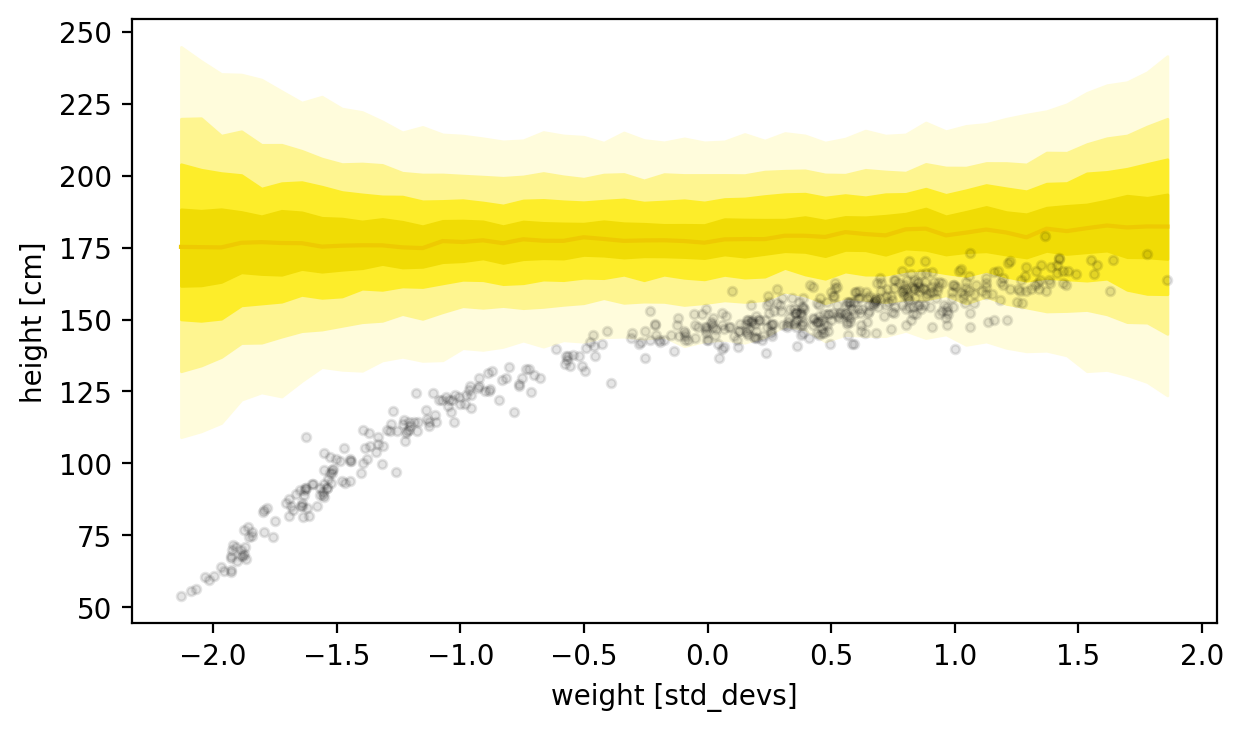

In [57]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes=ribbon_plot(data_sim['weight'],height_sim,axes)
axes.scatter(d.s_weight,d.height,color='black',alpha=0.1,s=10)
axes.set_xlabel('weight [std_devs]')
axes.set_ylabel('height [cm]')
plt.show()

In [58]:
az.summary(sim,var_names=['alpha','beta_1','beta_2','sigma'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,178.30,20.86,140.65,217.65
beta_1,1.61,1.85,0.04,4.59
beta_2,0.18,9.83,-19.22,18.21
sigma,15.12,14.64,0.01,40.79


In [59]:
with open('height_3_fit.stan', 'r') as file:
    print(file.read())

data {
  int N;
  vector[N] weight;
  real heights[N];
}

parameters {
  real alpha;
  real beta_1;
  real beta_2;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu;
  for (i in 1:N) {
    mu[i] = weight[i]*beta_1+weight[i]^2*beta_2+alpha;
  }
}

model {
  alpha ~ normal(178,20);
  beta_1 ~ lognormal(0,1);
  beta_2 ~ normal(0,10);
  sigma ~ exponential(0.067);
  heights ~ normal(mu,sigma);
}

generated quantities {
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(mu[i],sigma);
  }
}



In [60]:
model_3_fit=CmdStanModel(stan_file='height_3_fit.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmplqeui6z8/tmp3flyipq0
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 6 - Linear models/Kung_people/height_3_fit


In [61]:
data_fit=dict(N=len(d),
              weight=d.s_weight.values,
              heights=d.height.values)

fit=model_3_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


In [62]:

height_pred=fit.stan_variable('height')
beta_2 = fit.stan_variable('height')


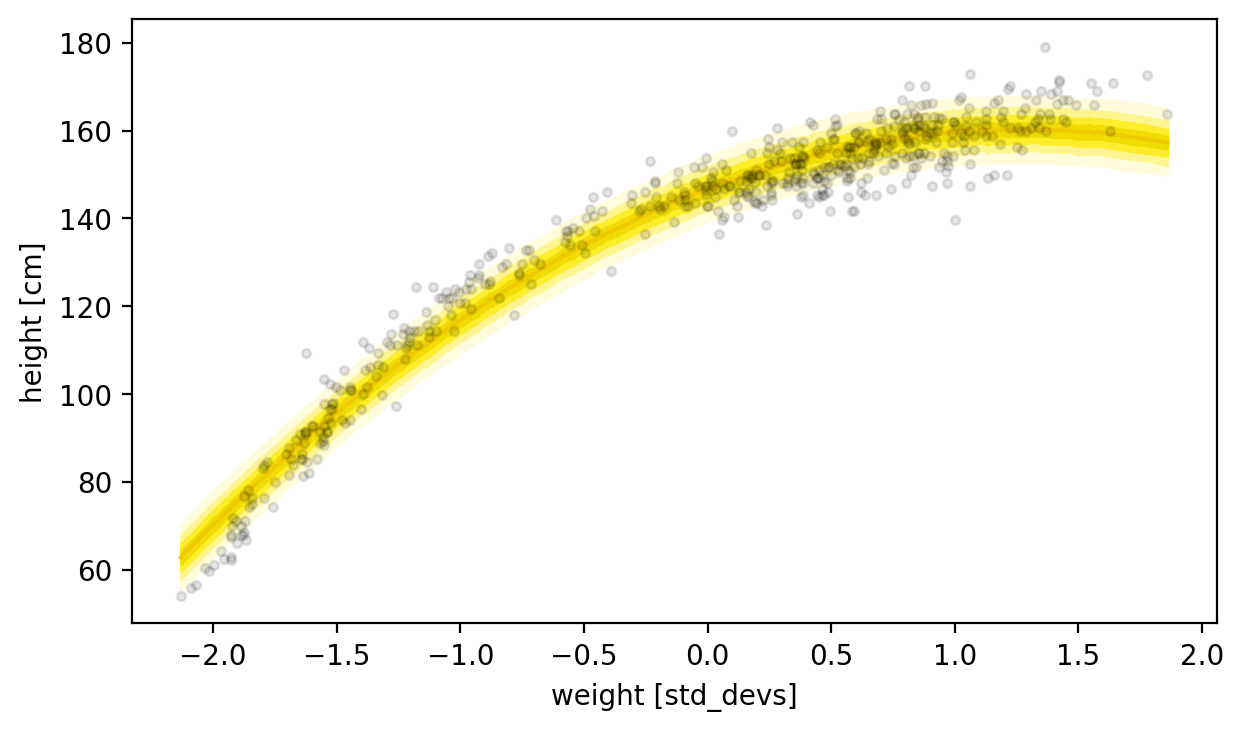

In [63]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes=ribbon_plot(d.s_weight.values,height_pred,axes,supress_warning=True)
axes.scatter(d.s_weight,d.height,color='black',alpha=0.1,s=10)
axes.set_xlabel('weight [std_devs]')
axes.set_ylabel('height [cm]')
plt.show()


In [64]:
az.summary(fit,var_names=['alpha','beta_1','beta_2','sigma'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,146.68,0.38,145.96,147.40
beta_1,21.40,0.29,20.86,21.96
beta_2,-8.42,0.29,-8.96,-7.88
sigma,5.78,0.18,5.45,6.11


### Is this the most efficient way of adding predictors?
Obviously not, functions of predictors can be computed earlier.

### Creating a design matrix

In [65]:
d.head()

,height,weight,age,male,c_weight,s_weight
0,151.765,47.825606,63.0,1,12.214989,0.829869
1,139.700,36.485807,63.0,0,0.875189,0.059459
2,136.525,31.864838,65.0,0,-3.745780,-0.254483
3,156.845,53.041914,41.0,1,17.431297,1.184257
4,145.415,41.276872,51.0,0,5.666254,0.384957


In [66]:
d['s_weight^2']=d['s_weight']**2
d['s_weight^3']=d['s_weight']**3

In [67]:
d.head()

,height,weight,age,male,c_weight,s_weight,s_weight^2,s_weight^3
0,151.765,47.825606,63.0,1,12.214989,0.829869,0.688682,0.571516
1,139.700,36.485807,63.0,0,0.875189,0.059459,0.003535,0.000210
2,136.525,31.864838,65.0,0,-3.745780,-0.254483,0.064762,-0.016481
3,156.845,53.041914,41.0,1,17.431297,1.184257,1.402466,1.660881
4,145.415,41.276872,51.0,0,5.666254,0.384957,0.148192,0.057048


In [68]:
X=d.iloc[:,-3:].values

In [69]:
with open('height_4_fit.stan', 'r') as file:
    print(file.read())

data {
  int N; //number of measurements
  int K; //number of predictors
  matrix [N,K] X; //design matrix
  real heights[N];
}

parameters {
  real alpha;
  vector[K] beta;

  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu = X*beta+alpha;
}

model {
  alpha ~ normal(178,20);
  beta ~ normal(0,10);
  sigma ~ exponential(0.067);
  heights ~ normal(mu,sigma);
}

generated quantities {
  real height[N];
  for (i in 1:N) {
    height[i] = normal_rng(mu[i],sigma);
  }
}



In [70]:
model_4_fit=CmdStanModel(stan_file='height_4_fit.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpjn5489ca/tmp5wefznfy
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 6 - Linear models/Kung_people/height_4_fit


In [71]:
data_fit=dict(N=len(d),
              K=3, 
              X=X,
              heights=d.height.values)
fit=model_4_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


In [72]:
height_pred=fit.stan_variable('height')


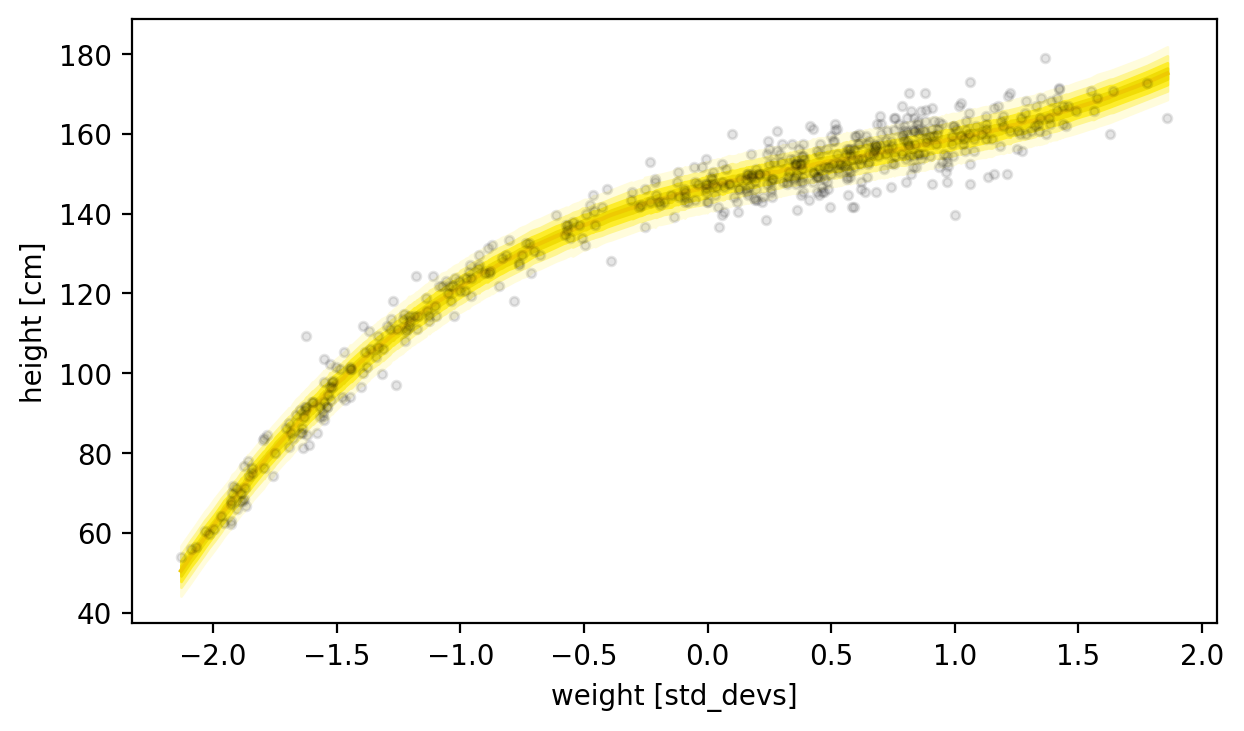

In [73]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes=ribbon_plot(d.s_weight.values,height_pred,axes,supress_warning=True)
axes.scatter(d.s_weight,d.height,color='black',alpha=0.1,s=10)
axes.set_xlabel('weight [std_devs]')
axes.set_ylabel('height [cm]')
plt.show()


In [74]:
az.summary(fit,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,146.74,0.32,146.14,147.32
beta[0],15.01,0.49,14.13,15.97
beta[1],-6.55,0.27,-7.04,-6.04
beta[2],3.59,0.24,3.15,4.03
sigma,4.85,0.15,4.59,5.13
